# Understanding customers

## Data Source
The mall customer dataset is a hypothetical dataset containing various attributes about customers such as gender, age, and annual income.

## Dataset Attributes
* CustomerID: unique customer identification number  
* Gender: customer gender (Male or Female)  
* Age: customer age in years  
* Annual Income: annual customer income (thousands of dollars)  
* Spending Score: a score based on customer behaviour and spending habits





In [1]:
# Import libraries

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, silhouette_score

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Objective
Segment customers into groups to facilitate tailored marketing, product offerings and services.

## Load and explore data

In [2]:
# Load data
df = pd.read_csv('Mall_Customers.csv',index_col=0)

print('Data:')
print(df.head(), end='\n\n')

# Check if there are missing values
print(df.isnull().sum(), end='\n\n')

# Check if there are non-numerical features
print(df.info())


Data:
             Genre  Age  Annual Income (k$)  Spending Score (1-100)
CustomerID                                                         
1             Male   19                  15                      39
2             Male   21                  15                      81
3           Female   20                  16                       6
4           Female   23                  16                      77
5           Female   31                  17                      40

Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Genre                   200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200

## Preprocessing and Feature Selection

In [3]:
# Rename the misnamed feature "Genre" 
df = df.rename(columns={'Genre': 'Gender'})


Recall that to use categorical features we need to encode them. Refresh your knowledge about the [three types of encoding](https://www.datacamp.com/tutorial/categorical-data) if you need to.

In [4]:
# Label encode the Gender feature
df['Gender'] = LabelEncoder().fit_transform(df['Gender'])

As part of the preprocessing we are also going to do some feature selection. Not all features will have equal impact on the outcome variable, and some will have no impact at all. It is better to train your model with only significant features, both to lower runtime and improve results. We will plot our data to see which feature best allows us to group customers aside from the variable we are most interested in, which is spending.

([<matplotlib.axis.XTick at 0x1452bcec0>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

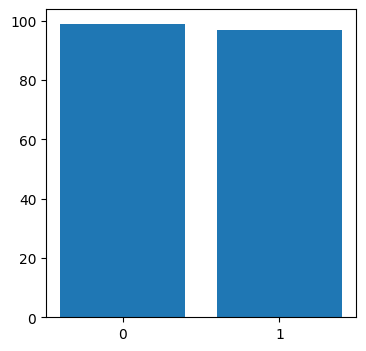

In [5]:
# Explore the binary independent feature (Gender)

plt.figure(figsize=(4, 4))
plt.bar(df['Gender'], df['Spending Score (1-100)'], width=0.8)
plt.xticks([0,1])

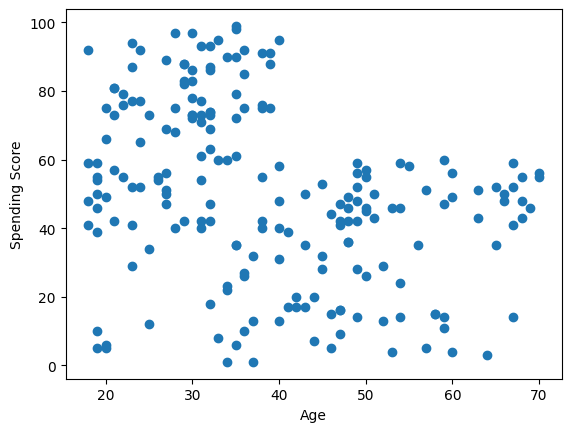

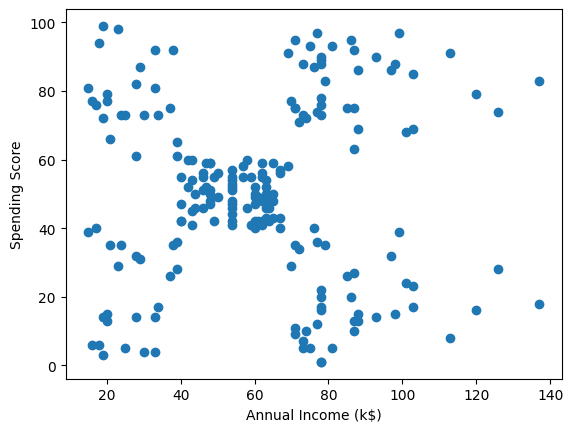

In [6]:
# Explore the continuous independent features (Age and Annual Income)

for f in df.columns[1:-1]:
  plt.scatter(df[f], df['Spending Score (1-100)'])
  plt.xlabel(f)
  plt.ylabel('Spending Score')
  plt.show()

The Annual Income feature naturally divides the data into 5 clusters. Since these are clusters are quite distinct we will use this feature to perform clustering on.

## K-Means Clustering

### Selecting K

In [7]:
# Prepare data for clustering, note that we do not supply y in an unsupervised learning task.
X = df[['Annual Income (k$)','Spending Score (1-100)']].values.reshape(-1,2)  

print('Data size:')
print(X.shape)

Data size:
(200, 2)



It is clear from the distribution of the data choosing 5 clusters is a likely option for our choice of K.

However, for illustration purposes, we will also show you the so-called elbow method for choosing a value for K. The elbow method is commonly used strategy in which the algorithm is run multiple times with increasing values of K. This is then plotted against the sum of squared distances of samples to their closest cluster center (called inertia). The value of K to choose is identified from the resulting plot where there is an 'elbow' in the graph. 

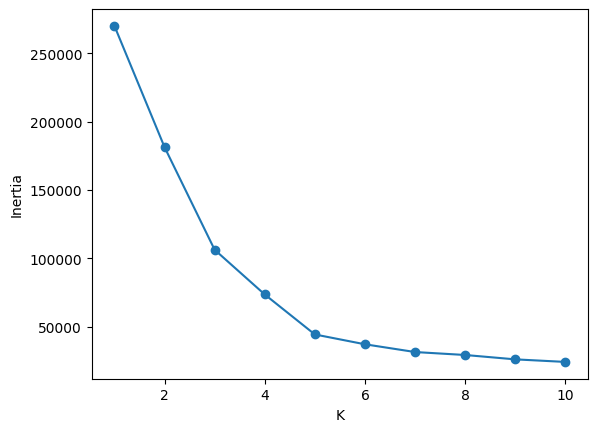

In [8]:
def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r)
    kmeans.fit(x)    
    return kmeans.inertia_

def elbow_Kmeans(x, max_k=10, r=123):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1, max_k+1)]
    plt.plot(range(1, 11), within_cluster_vars,marker='o')
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.show()

elbow_Kmeans(X)


The elbow runs from K=3 to K=5. In cases like this, it is not always clear which value within the elbow is the most optimal, so we can investigate likely candidates further using the silhouette score. 

### Fit a K-Means Model and Visualise the Outcome 

Let's illustrate the differences with a scatter plot. Note how the silhouette score increases considerably between K=4 and K=5, but not between K=5 and K=6.

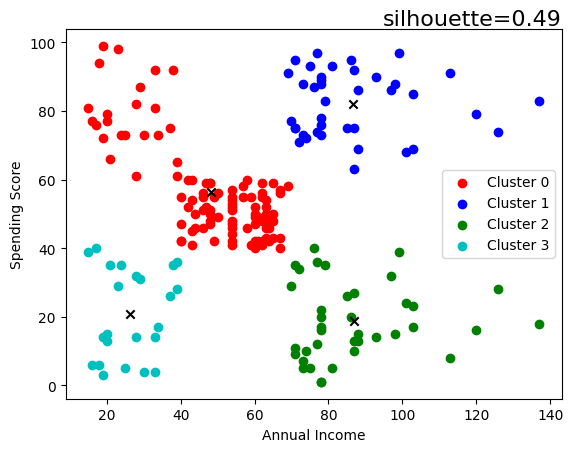

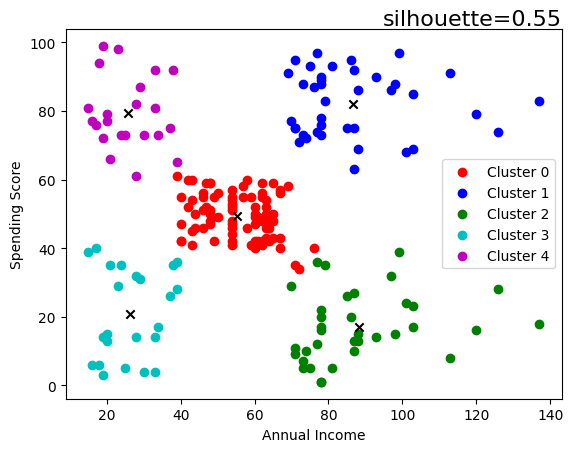

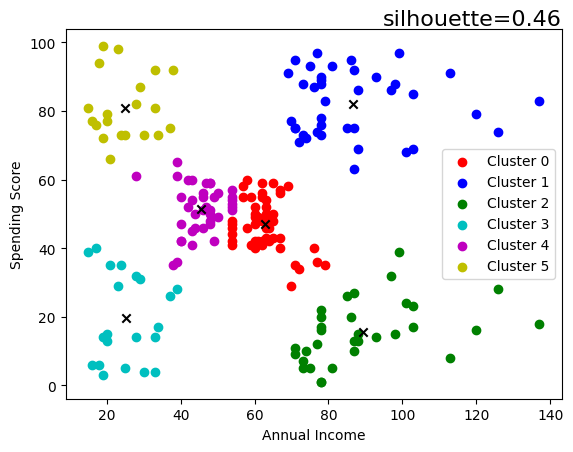

In [9]:
def scatter_Kmeans(x, k, r=123):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=r)
    y_pred = kmeans.fit_predict(x)
    colours = 'rbgcmy'
    for c in range(k):
      plt.scatter(x[y_pred == c, 0], x[y_pred == c,1], c = colours[c], label = 'Cluster {}'.format(c))
      plt.scatter(kmeans.cluster_centers_[c, 0], kmeans.cluster_centers_[c, 1], marker='x', c = 'black')
    
    score = round(silhouette_score(X, kmeans.labels_, metric='euclidean'), 2)
    plt.title('silhouette={}'.format(score), loc='right', fontdict={'fontsize': 16}, pad=-14)
    plt.xlabel('Annual Income')
    plt.ylabel('Spending Score')
    plt.legend()
    plt.show()

for k in range(4,7):
  scatter_Kmeans(X, k, r=0)
  

Thus we see that the best silhouette score is achieved using K=5.